In [1]:
import re

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from umap import UMAP
from joblib import load

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.style.use("publication")

In [2]:
df = pd.read_pickle("../../data/processed/tmc1_ready.pkl")

In [3]:
df = df.loc[df["Formula"] != "H2"]

df.reset_index(inplace=True, drop=True)

In [4]:
df["Column density (cm^-2)"] /= 1e11

In [5]:
embedder = load("../../models/EmbeddingModel.pkl")

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.24

In [6]:
vectors = np.vstack([embedder.vectorize(smi) for smi in df["SMILES"].tolist()])

In [7]:
manifold_model = UMAP(n_neighbors=30, min_dist=0.05, spread=3., random_state=100, metric="cosine", repulsion_strength=1.2)

In [8]:
projection = manifold_model.fit_transform(vectors)

In [9]:
projection.shape

(87, 2)

In [10]:
df["Category"] = 0

In [11]:
df.loc[df["SMILES"].str.contains("N"), "Category"] = 1

In [12]:
df.loc[df["Formula"].str.contains("O"), "Category"] = 2

In [13]:
df.loc[df["Formula"].str.contains("S"), "Category"] = 3

In [14]:
df.iloc[[3, 4]].loc["Category"] = 4

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [15]:
colors = ["#8361b3",
"#6da55b",
"#b74861",
"#c1803c"]

color_dict = {key: colors[key] for key in range(4)}

In [16]:
df["Color"] = df["Category"].map(color_dict)

In [17]:
labels = ["Hydrocarbon", "Nitrogen", "Oxygen", "Sulfur"]
label_dict = {key: labels[key] for key in range(len(labels))}

In [18]:
df["Label"] = df["Category"].map(label_dict)

In [19]:
polyynes = [f"HC{n}N" for n in range(3, 13, 2)]

In [20]:
polyyne_indices = df.loc[df["Formula"].isin(polyynes)].index

In [21]:
# skip out on the first cyanonaphthalene because it's big
big = df.loc[df["Formula"].isin(["C11H7N", "C5H5CN", "C6H5CN"])].iloc[[0, 2, 4]]

In [22]:
sulfurs = df.loc[(df["Category"] == 3) & (df["Molecule"].isin(["Carbon monosulfide", "Dicarbon monosulfide", "Thioformaldehyde"]))]

In [23]:
cyanides = df.loc[(df["Category"] == 1) & (df["Molecule"].isin(["Methyl cyanide", "Cyanomethyl radical", "2-cyanoethylidyl radical", "Vinylcyanide"]))]

## Polynomial fit to the projection

In [24]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [25]:
poly_model = make_pipeline(PolynomialFeatures(degree=1), Ridge())
poly_model.fit(projection[:,0][:,None], projection[:,1])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('ridge', Ridge())])

In [26]:
x = np.linspace(projection[:,0].min() - 0.5, projection[:,0].max() + 0.5, 1000)
y = poly_model.predict(x[:,None])

In [27]:
def reformat_chemical_formula(formula: str) -> str:
    # this regex looks for sequential digits
    numerals = re.compile("\d{1,}")
    charges = re.compile("\d?[\+\-]")
    # use set to look at only unique entries to prevent replacing twice
    for number in set(numerals.findall(formula)):
        formula = formula.replace(number, "$_{" + number + "}$")
    for sign in set(charges.findall(formula)):
        formula = formula.replace(sign, "$^" + sign + "$")
    return formula

In [28]:
cps = df.loc[df["SMILES"].isin(["C#N", "C#CC#N", "C#CC#CC#N", "C#CC#CC#CC#N", "C#CC#CC#CC#CC#N", "C#CC#CC#CC#CC#CC#CC#N"])].index.values

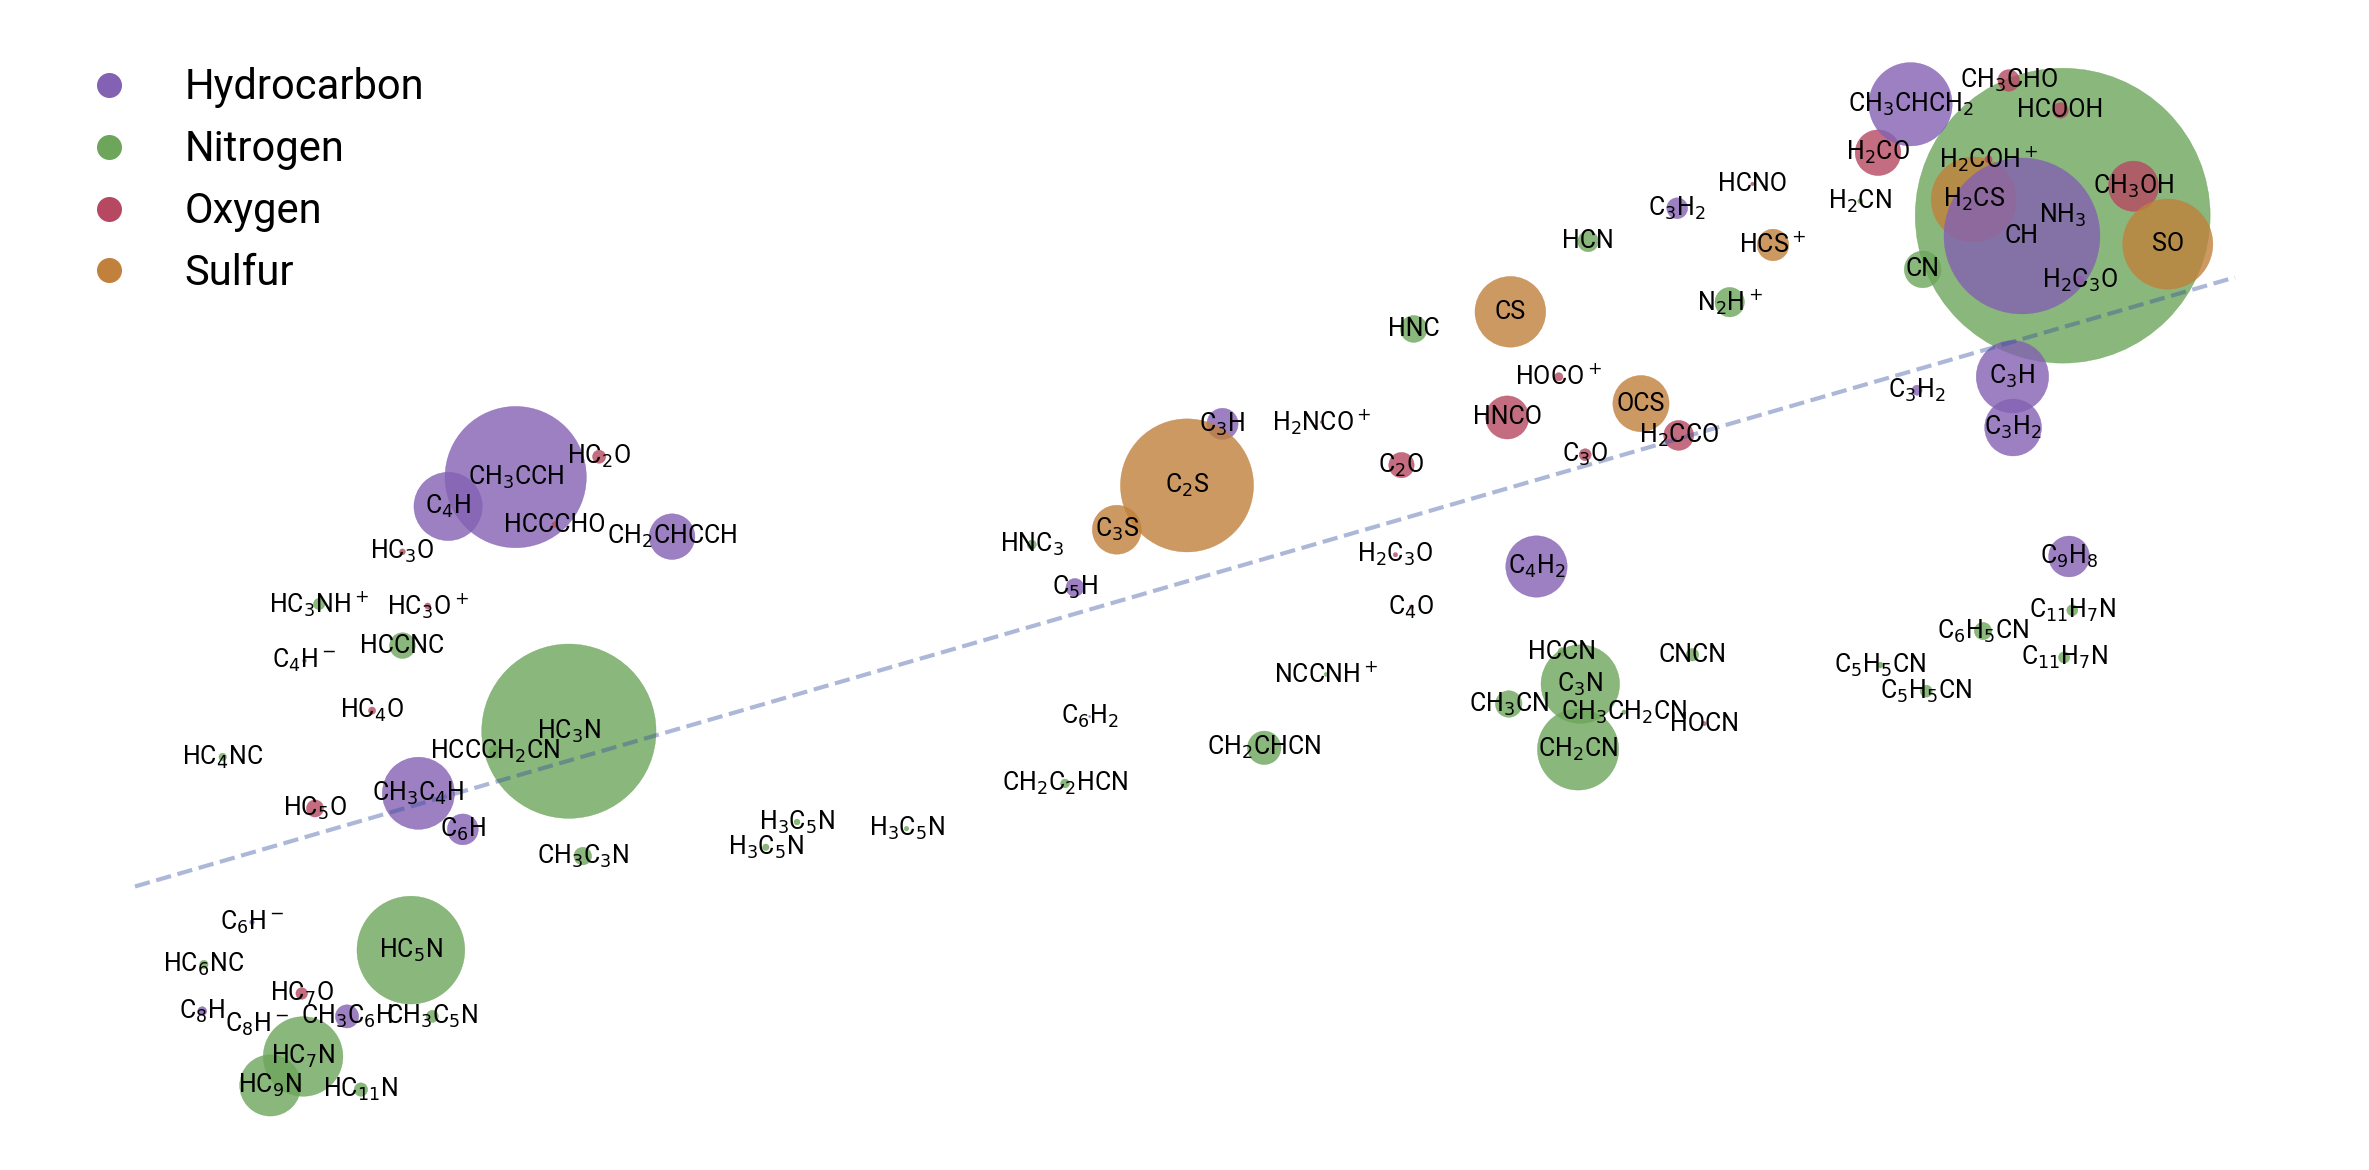

In [29]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(x, y, alpha=0.4, ls="--")
ax.scatter(projection[:,0], projection[:,1], s=df["Column density (cm^-2)"], alpha=0.8, lw=0.1, c=df["Color"])
# ax.plot(projection[cps,0], projection[cps,1])

done = list()

for index, row in df.iterrows():
    formula = row["Formula"]
    formatted = reformat_chemical_formula(formula)
    # if formula not in done:
    ax.text(projection[index,0], projection[index, 1], formatted, horizontalalignment="center", verticalalignment="center", fontsize=6.)
    done.append(formula)

legend_elements = [
    Line2D([0], [0], marker="o", lw=0., color=colors[index], label=labels[index]) for index in range(4)
]
ax.legend(handles=legend_elements)
    
ax.set(xticks=[], yticks=[])
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

# fig.savefig("umap_tmc1_viz.svg", dpi=300, transparent=True)
fig.savefig("../../reports/figures/umap_tmc1_viz_alllabel.pdf", dpi=300, transparent=True)

## Visualization with KIDA

In [30]:
from umda.smi_vec import inchi_to_smiles

kida_df = pd.read_csv("../../data/external/kida-molecules_05_Jul_2020.csv")
kida_df["SMILES"] = kida_df["InChI"].apply(inchi_to_smiles)

RDKit WARNING: [15:20:03] expect radical to be either 2 or 3 while getting . Ignore radical.
RDKit WARNING: [15:20:03] expect radical to be either 2 or 3 while getting . Ignore radical.
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s): Do not match)
RDKit WARNING: [15:20:03] WARNING:  Problems/mismatches: Mobile-H( Charge(s)

In [31]:
def vectorize_kida(smi):
    try:
        return embedder.vectorize(smi)
    except (ValueError, TypeError):
        return None

In [32]:
kida_vecs = kida_df["SMILES"].apply(vectorize_kida)

In [33]:
kida_vecs = np.vstack(list(filter(lambda x: all([x is not None, type(x) == np.ndarray]), kida_vecs)))

In [34]:
combined = np.vstack([kida_vecs, vectors])

In [35]:
manifold_model = UMAP(n_neighbors=400, min_dist=0.05, spread=3., random_state=100, metric="euclidean", repulsion_strength=1.2)
new_umap = manifold_model.fit_transform(combined)

In [36]:
bigguns = df.loc[df["Formula"].isin(["C11H7N", "C9H8", "C5H5CN"])].index.values

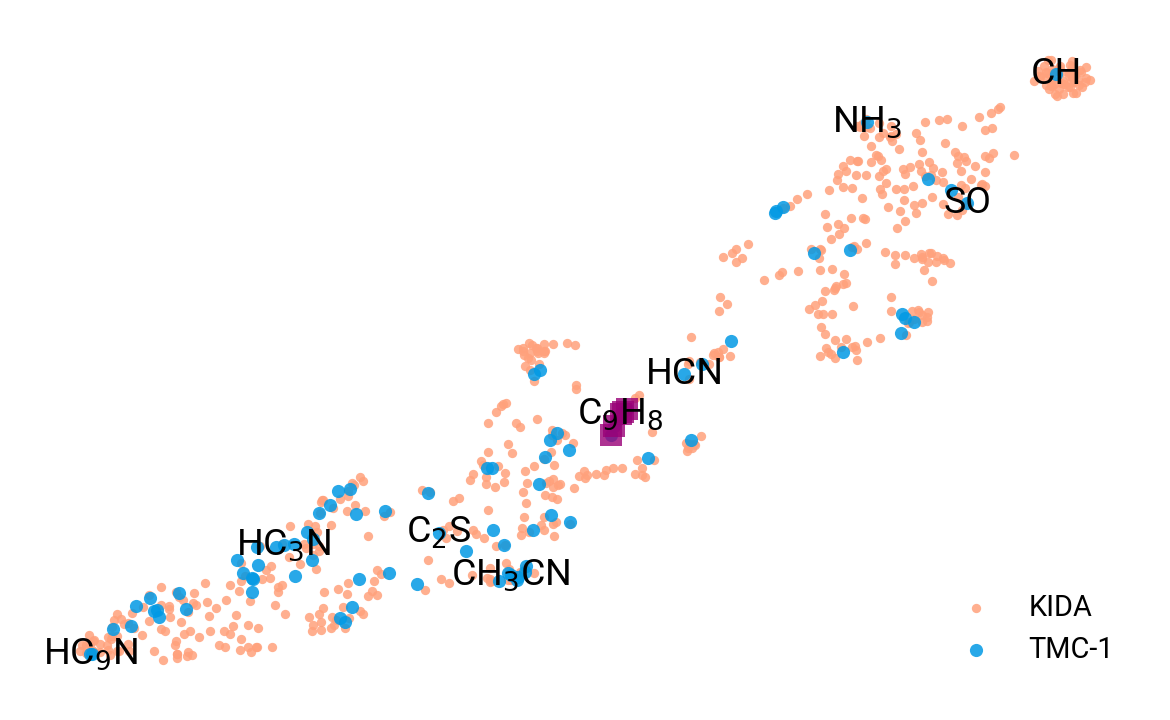

In [50]:
fig, ax = plt.subplots(figsize=(4, 2.5))

num_kida = len(kida_vecs)

ax.scatter(new_umap[:num_kida,0], new_umap[:num_kida,1], s=5, alpha=0.85, linewidths=0., label="KIDA", c="#ffa17c")
ax.scatter(new_umap[num_kida:,0], new_umap[num_kida:,1], s=10, alpha=0.85, linewidths=0., label="TMC-1", c="#0299e4")
ax.scatter(new_umap[num_kida + bigguns, 0], new_umap[num_kida + bigguns,1], s=30, alpha=0.8, linewidths=0., marker="s", c="#990077")
ax.set(xticks=[], yticks=[])
ax.legend(fontsize="x-small", loc="lower right")
for spine in ax.spines.values():
    spine.set_visible(False)

for index, row in df.loc[df["Formula"].isin(["HC9N", "CH", "NH3", "SO", "HCN", "C2S", "HC3N", "CH3CN", "C9H8"])].iterrows():
    formula = row["Formula"]
    formatted = reformat_chemical_formula(formula)
    # if formula not in done:
    ax.text(new_umap[index + num_kida,0], new_umap[index + num_kida, 1], formatted, horizontalalignment="center", verticalalignment="center", fontsize=9., zorder=20)
    done.append(formula)

fig.savefig("../../reports/figures/kida_tmc1_umap.pdf", dpi=300)

In [51]:
with open("../../scripts/targets.smi", "r") as read_file:
    recs = read_file.read().split("\n")

In [52]:
rec_vecs = np.vstack([embedder.vectorize(smi) for smi in recs])

In [53]:
combined = np.vstack([kida_vecs, vectors, rec_vecs])

manifold_model = UMAP(n_neighbors=400, min_dist=0.05, spread=3., random_state=100, metric="euclidean", repulsion_strength=1.2)
manifold_model = manifold_model.fit(combined)

trans_tmc = manifold_model.transform(vectors)
trans_kida = manifold_model.transform(kida_vecs)
trans_recs = manifold_model.transform(rec_vecs)

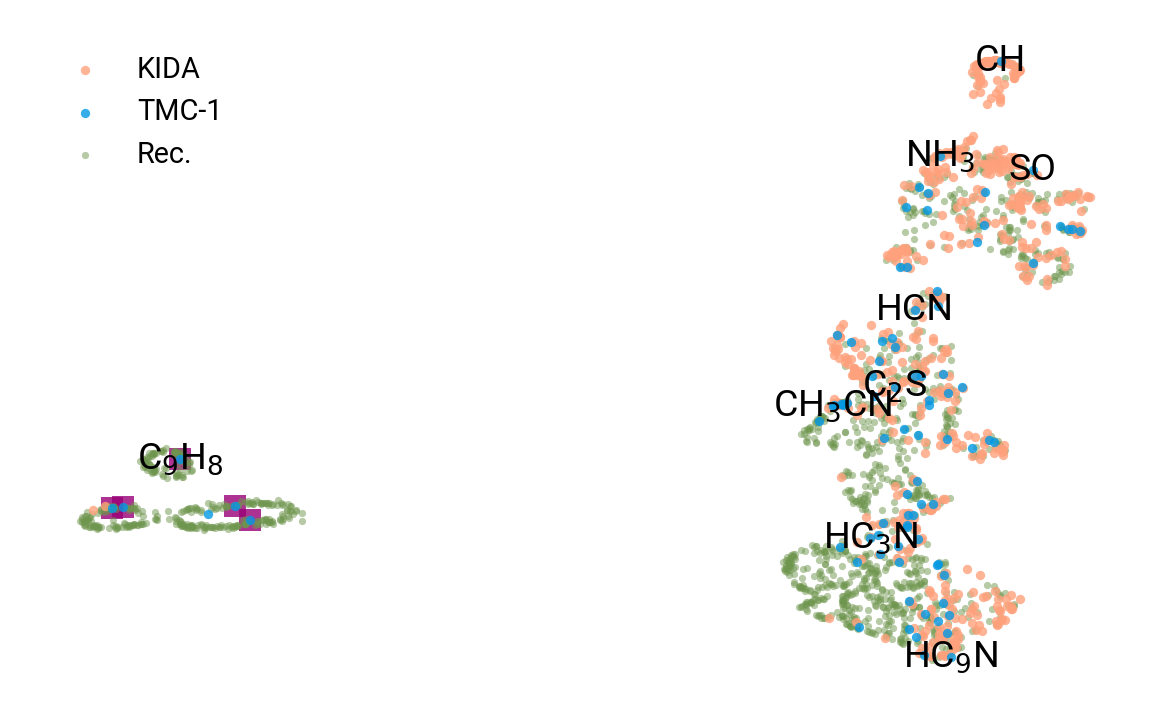

In [60]:
fig, ax = plt.subplots(figsize=(4, 2.5))

num_kida = len(kida_vecs)

ax.scatter(trans_kida[:,0], trans_kida[:,1], s=5, alpha=0.8, linewidths=0., label="KIDA", c="#ffa17c", zorder=5)
ax.scatter(trans_tmc[:,0], trans_tmc[:,1], s=5, alpha=0.8, linewidths=0., label="TMC-1", c="#0299e4", zorder=5)
ax.scatter(trans_tmc[bigguns, 0], trans_tmc[bigguns,1], s=30, alpha=0.8, linewidths=0., marker="s", c="#990077")
ax.scatter(trans_recs[:,0], trans_recs[:,1], s=3., alpha=0.5, linewidths=0., c="#6f964e", label="Rec.", zorder=2)
ax.set(xticks=[], yticks=[])
ax.legend(fontsize="x-small", loc="upper left")
for spine in ax.spines.values():
    spine.set_visible(False)

for index, row in df.loc[df["Formula"].isin(["HC9N", "CH", "NH3", "SO", "HCN", "C2S", "HC3N", "CH3CN", "C9H8"])].iterrows():
    formula = row["Formula"]
    formatted = reformat_chemical_formula(formula)
    # if formula not in done:
    ax.text(trans_tmc[index,0], trans_tmc[index, 1], formatted, horizontalalignment="center", verticalalignment="center", fontsize=9., zorder=20)
    done.append(formula)

fig.savefig("../../reports/figures/rec_umap.pdf", dpi=300)